In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
nyt_cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv")
nyt_cases.date = pd.to_datetime(nyt_cases.date)


In [ ]:
locations = [('Texas', 'Harris', "Houston"),
             ('New York', 'New York City', "New_York_City"),
             ('California', 'San Diego', "San_Diego"),
             ('California', 'Santa Clara', "Santa_Clara_County"),
             ('Wisconsin', 'Dane', "Dane_County"),
             ('California', 'Alameda', "Alameda_County"),
             ('Washington', 'Yakima', "Yakima_County"),
             ('Washington', 'King', "King_County"),
             ('California', 'Orange', "Orange_County"),
             ('California', 'Los Angeles', "Los_Angeles_County")]

for state, location, data_loc in locations:
    location_data = glob(f"../data/{data_loc}_output/window_7_step_7/*/uncert.csv") +  glob(f"../data/output/{data_loc}/window_7_step_7/*/uncert.csv")
    print(location)
    print(len(location_data))

In [16]:
data_loc = "Houston"

location_data = glob(f"../data/{data_loc}_output/window_7_step_7/*/uncert.csv") +  glob(f"../data/output/{data_loc}/window_7_step_7/*/uncert.csv")
uncerts = []
for path in location_data:
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df.graph_name.apply(lambda row: row.split("_")[0]))
    uncerts.append(df)

uncert = pd.concat(uncerts)
uncert = uncert.groupby("date").max().drop(columns=["graph_name"])

In [17]:
uncert.index

DatetimeIndex(['2020-03-18', '2020-03-25', '2020-04-01', '2020-04-08',
               '2020-04-15', '2020-04-22', '2020-04-29', '2020-05-06',
               '2020-05-13', '2020-05-20', '2020-05-27', '2020-06-03',
               '2020-06-10', '2020-06-17', '2020-06-24', '2020-07-01',
               '2020-07-08', '2020-08-12', '2020-08-19', '2020-08-26',
               '2020-09-02', '2020-09-09', '2020-09-16', '2020-09-23',
               '2020-09-30', '2020-10-07', '2020-10-14', '2020-10-21',
               '2020-10-28', '2020-11-04', '2020-11-11', '2020-11-18',
               '2020-11-25', '2020-12-16', '2020-12-23', '2020-12-30',
               '2021-01-06', '2021-01-13', '2021-01-20', '2021-01-27',
               '2021-02-03', '2021-02-10', '2021-02-17', '2021-02-24',
               '2021-03-03'],
              dtype='datetime64[ns]', name='date', freq=None)

In [11]:
locations = [('Texas', 'Harris', "Houston"),
             ('New York', 'New York City', "New_York_City"),
             ('California', 'San Diego', "San_Diego"),
             ('California', 'Santa Clara', "Santa_Clara_County"),
             ('Wisconsin', 'Dane', "Dane_County"),
             ('California', 'Alameda', "Alameda_County"),
             ('Washington', 'Yakima', "Yakima_County"),
             ('Washington', 'King', "King_County"),
             ('California', 'Orange', "Orange_County"),
             ('California', 'Los Angeles', "Los_Angeles_County")]

location_dfs = []
location_dfs_abs = []
location_corrs = []
location_corrs_abs = []
rolling = True
only_pos = True
location_samples = []
for state, location, data_loc in locations:
    cases = nyt_cases[(nyt_cases.state == state) & (nyt_cases.county == location)]
    cases = cases.pivot(index="date", columns="fips", values="cases")
    cases = cases.diff()
    if rolling:
        cases = cases.rolling(7).mean() #Should I take the mean here?
    cases.columns = ["cases"]
    
    location_data = glob(f"../data/{data_loc}_output/window_7_step_7/*/uncert.csv") +  glob(f"../data/output/{data_loc}/window_7_step_7/*/uncert.csv")
    uncerts = []
    for path in location_data:
        df = pd.read_csv(path)
        df["date"] = pd.to_datetime(df.graph_name.apply(lambda row: row.split("_")[0]))
        uncerts.append(df)

    uncert = pd.concat(uncerts)
    uncert = uncert.groupby("date").max().drop(columns=["graph_name"]).diff() #.dropna()
    if uncert.index.min() < cases.index.min():
        uncert = uncert.iloc[1:]
    uncert_cases = cases.loc[uncert.index.min():].resample("7D").sum().diff()
    if only_pos:
        uncert_cases = uncert_cases[uncert_cases > 0]
#     print(cases.loc[uncert.index.min():].head(20))
#     print(uncert_cases.index.min())
    sample_sizes = []
    granger_ps = {col:[] for col in uncert.columns}
    for col_name in uncert.columns:
        col = uncert[col_name]
        granger_df = pd.concat([uncert_cases.cases, col], axis=1).dropna()
        sample_sizes.append((col_name, granger_df.shape[0]))
#         print(uncert_cases.index)
#         print(col.index)
#         print(location, col_name, sample_sizes[-1], min(granger_df.shape[0]-20, 12))
        try:
            granger_results = grangercausalitytests(granger_df, min(granger_df.shape[0]-20, 12), verbose=False)
        except:
            try:
                granger_results = grangercausalitytests(granger_df, 11, verbose=False) #For Yakima
            except: 
                try:
                    granger_results = grangercausalitytests(granger_df, 9, verbose=False) #For Yakima
                except:
                    granger_results = grangercausalitytests(granger_df, 5, verbose=False) #For Yakima
                
            
        for lag in range(1, 13):
            try:
                p_value = granger_results[lag][0]['ssr_chi2test'][1]
            except:
                p_value = np.nan
            granger_ps[col_name].append(p_value)
            
    location_samples.append(sample_sizes)
    
    granger_ps = pd.DataFrame(granger_ps)
    granger_ps.index = [f"lag_{i}" for i in range(1,13)]
    granger_ps_check = granger_ps < 0.05
    
    corrs = {col:[] for col in uncert.columns}
    for col_name in uncert.columns:
        col = uncert[col_name].abs()
        for lag in range(1, 13):
            shifted_col = col.shift(lag)
            corr = uncert_cases["cases"].corr(shifted_col)
            corrs[col_name].append(corr)
    corrs = pd.DataFrame(corrs)
    corrs.index = [f"lag_{i}" for i in range(1,13)]
    corrs_check_abs = corrs.abs() > 0.25

    passed_combos_abs = corrs[(corrs_check_abs) & (granger_ps_check)].melt(ignore_index=False)

    corrs = corrs.melt(ignore_index=False).reset_index()
    corrs.columns = ["lag", "model", "correlation"]
    corrs["location"] = location
    
    location_corrs_abs.append(corrs)

    corrs = {col:[] for col in uncert.columns}
    for col_name in uncert.columns:
        col = uncert[col_name]
        for lag in range(1, 13):
            shifted_col = col.shift(lag)
            corr = uncert_cases["cases"].corr(shifted_col)
            corrs[col_name].append(corr)
    corrs = pd.DataFrame(corrs)
    corrs.index = [f"lag_{i}" for i in range(1,13)]
    corrs_check = corrs.abs() > 0.25
    
    passed_combos = corrs[(corrs_check) & (granger_ps_check)].melt(ignore_index=False)
    
    corrs = corrs.melt(ignore_index=False).reset_index()
    corrs.columns = ["lag", "model", "correlation"]
    corrs["location"] = location
    location_corrs.append(corrs)
    
    passed_combos_abs = passed_combos_abs.reset_index().dropna()
    passed_combos_abs.columns = ["lag", "model", "correlation"]
    passed_combos_abs["location"] = location
    
#     passed_combos = corrs[(corrs_check) & (granger_ps_check)].melt(ignore_index=False)
    passed_combos = passed_combos.reset_index().dropna()
    passed_combos.columns = ["lag", "model", "correlation"]
    passed_combos["location"] = location
    
#     try:
#         print(passed_combos.iloc[0])
#     except:
#         pass
    
    location_dfs.append(passed_combos)    
    location_dfs_abs.append(passed_combos_abs)

In [ ]:
location_samples

In [55]:
correlations = pd.concat(location_corrs)
correlations = correlations.pivot_table(index=["lag", "model"], columns="location", values="correlation", aggfunc=np.mean).reset_index()
correlations = correlations[~correlations["model"].isin(["aa_full_sequences_1_genomes_1", "aa_full_sequences_0_genomes_0"])]
correlations["lag_val"] = correlations.lag.apply(lambda row: int(row.split("_")[1]))
correlations = correlations.sort_values(["lag_val", "model"])
correlations = correlations.drop(columns=["lag_val"])
# correlations.to_csv("simple_correlations_pos_only.csv", index=False)
cm = sns.light_palette("blue", as_cmap=True)
s = correlations.style.background_gradient(cmap=cm)
s
max_df = {"location":[], "lag":[], "model":[], "value":[]}
for location, idx in correlations.set_index(["lag", "model"]).idxmax().reset_index().to_numpy():
    value = correlations.set_index(["lag", "model"])[location].loc[idx]
    max_df["location"].append(location)
    max_df["lag"].append(idx[0])
    max_df["model"].append(idx[1])
    max_df["value"].append(value)
max_df = pd.DataFrame(max_df)
cm = sns.light_palette("blue", as_cmap=True)
s = max_df.style.background_gradient(cmap=cm)
s

,location,lag,model,value
0,Alameda,lag_1,full_sequences_0_genomes_1,0.434793
1,Dane,lag_12,aa_collapsed_sequences_0_genomes_0,0.588757
2,Harris,lag_4,aa_full_sequences_0_genomes_1,0.389381
3,King,lag_1,full_sequences_1_genomes_0,0.435571
4,Los Angeles,lag_7,aa_full_sequences_0_genomes_1,0.230666
5,New York City,lag_3,aa_collapsed_sequences_0_genomes_0,0.526871
6,Orange,lag_10,aa_full_sequences_0_genomes_1,0.315567
7,San Diego,lag_4,aa_full_sequences_1_genomes_0,0.402035
8,Santa Clara,lag_1,aa_full_sequences_0_genomes_1,0.477928
9,Yakima,lag_6,aa_collapsed_sequences_0_genomes_0,0.511121


In [16]:
correlations = pd.concat(location_corrs_abs)
correlations = correlations.pivot_table(index=["lag", "model"], columns="location", values="correlation", aggfunc=np.mean).reset_index()
correlations = correlations[~correlations["model"].isin(["aa_full_sequences_1_genomes_1", "aa_full_sequences_0_genomes_0"])]
correlations["lag_val"] = correlations.lag.apply(lambda row: int(row.split("_")[1]))
correlations = correlations.sort_values(["lag_val", "model"])
correlations = correlations.drop(columns=["lag_val"])
# correlations.to_csv("absolute_value_of_difference_correlations_pos_only.csv", index=False)
cm = sns.light_palette("blue", as_cmap=True)
s = correlations.style.background_gradient(cmap=cm)
# s

# max_df = {"location":[], "lag":[], "model":[], "value":[]}
# for location, idx in correlations.set_index(["lag", "model"]).idxmax().reset_index().to_numpy():
#     value = correlations.set_index(["lag", "model"])[location].loc[idx]
#     max_df["location"].append(location)
#     max_df["lag"].append(idx[0])
#     max_df["model"].append(idx[1])
#     max_df["value"].append(value)
# max_df = pd.DataFrame(max_df)
# cm = sns.light_palette("blue", as_cmap=True)
# s = max_df.style.background_gradient(cmap=cm)
# s

In [16]:
correlations["lag_model"] = correlations.lag + "_" + correlations.model
correlations = correlations.drop(columns=["lag", "model"]).set_index("lag_model")
best_lag_models = correlations.mean(axis=1).abs().sort_values(ascending=False).head(5).index
# best_lag_models
best_correlations = correlations.loc[best_lag_models]

cm = sns.light_palette("blue", as_cmap=True)
s = best_correlations.style.background_gradient(cmap=cm)
s

location,Alameda,Dane,Harris,King,Los Angeles,New York City,Orange,San Diego,Santa Clara,Yakima
lag_model,,,,,,,,,,
lag_4_full_sequences_1_genomes_0,0.363880,0.456871,0.325009,0.239744,0.378736,0.457592,0.323861,-0.042326,0.065693,0.492506
lag_4_full_sequences_0_genomes_1,0.482264,0.506847,0.521793,-0.083886,0.142225,0.473095,0.139119,-0.094087,0.091198,0.336461
lag_8_collapsed_sequences_0_genomes_1,-0.250646,-0.321660,-0.512111,-0.251901,-0.004895,-0.347757,-0.141849,-0.212360,-0.206505,-0.148693
lag_2_full_sequences_1_genomes_0,0.268169,0.119829,0.607768,0.119761,0.017522,0.171730,0.392004,0.074310,0.429790,0.111637
lag_2_aa_full_sequences_0_genomes_1,0.251398,0.581252,0.427912,0.438269,-0.177944,0.233296,0.021930,0.454004,-0.010032,0.085213


In [39]:
correlations.shape[0]

144

In [8]:
correlations = pd.concat(location_dfs)
correlations = correlations.pivot_table(index=["lag", "model"], columns="location", values="correlation", aggfunc=np.mean).reset_index()
correlations = correlations[~correlations["model"].isin(["aa_full_sequences_1_genomes_1", "aa_full_sequences_0_genomes_0"])]
correlations["lag_val"] = correlations.lag.apply(lambda row: int(row.split("_")[1]))
correlations = correlations.sort_values(["lag_val", "model"])
correlations = correlations.drop(columns=["lag_val"])
# correlations.to_csv("simple_correlations_and_granger_pos_only.csv", index=False)
cm = sns.light_palette("blue", as_cmap=True)
s = correlations.style.background_gradient(cmap=cm)
# s

max_df = {"location":[], "lag":[], "model":[], "value":[]}
for location, idx in correlations.set_index(["lag", "model"]).idxmax().reset_index().to_numpy():
    value = correlations.set_index(["lag", "model"])[location].loc[idx]
    max_df["location"].append(location)
    max_df["lag"].append(idx[0])
    max_df["model"].append(idx[1])
    max_df["value"].append(value)
max_df = pd.DataFrame(max_df)
cm = sns.light_palette("blue", as_cmap=True)
s = max_df.style.background_gradient(cmap=cm)
s

,location,lag,model,value
0,Alameda,lag_6,full_sequences_0_genomes_1,0.364249
1,Dane,lag_1,aa_collapsed_sequences_1_genomes_1,-0.255451
2,Harris,lag_4,aa_full_sequences_0_genomes_1,0.389381
3,King,lag_1,full_sequences_0_genomes_1,0.365337
4,Los Angeles,lag_6,aa_collapsed_sequences_0_genomes_1,-0.250100
5,New York City,lag_5,full_sequences_0_genomes_1,-0.259724
6,San Diego,lag_4,aa_collapsed_sequences_0_genomes_1,0.398239
7,Santa Clara,lag_1,aa_full_sequences_0_genomes_1,0.477928
8,Yakima,lag_5,full_sequences_0_genomes_1,0.374108


In [4]:
correlations = pd.concat(location_dfs_abs)
correlations = correlations.pivot_table(index=["lag", "model"], columns="location", values="correlation", aggfunc=np.mean).reset_index()
correlations = correlations[~correlations["model"].isin(["aa_full_sequences_1_genomes_1", "aa_full_sequences_0_genomes_0"])]
correlations["lag_val"] = correlations.lag.apply(lambda row: int(row.split("_")[1]))
correlations = correlations.sort_values(["lag_val", "model"])
correlations = correlations.drop(columns=["lag_val"])
# correlations.to_csv("absolute_value_of_difference_correlations_and_granger_pos_only.csv", index=False)
cm = sns.light_palette("blue", as_cmap=True)
s = correlations.style.background_gradient(cmap=cm)
# s

max_df = {"location":[], "lag":[], "model":[], "value":[]}
for location, idx in correlations.set_index(["lag", "model"]).idxmax().reset_index().to_numpy():
    value = correlations.set_index(["lag", "model"])[location].loc[idx]
    max_df["location"].append(location)
    max_df["lag"].append(idx[0])
    max_df["model"].append(idx[1])
    max_df["value"].append(value)
max_df = pd.DataFrame(max_df)
cm = sns.light_palette("blue", as_cmap=True)
s = max_df.style.background_gradient(cmap=cm)
s

,location,lag,model,value
0,Alameda,lag_8,collapsed_sequences_0_genomes_1,-0.250646
1,Dane,lag_2,aa_collapsed_sequences_1_genomes_0,0.452785
2,Harris,lag_2,aa_collapsed_sequences_1_genomes_0,0.506652
3,Los Angeles,lag_4,collapsed_sequences_0_genomes_0,0.752902
4,New York City,lag_5,full_sequences_0_genomes_1,0.707005
5,San Diego,lag_6,aa_collapsed_sequences_0_genomes_0,0.432227
6,Santa Clara,lag_1,full_sequences_1_genomes_0,0.807185
7,Yakima,lag_4,full_sequences_1_genomes_0,0.492506


In [ ]:
import pandas 
import seaborn as sns

correlations = pd.read_csv("simple_correlations_and_granger.csv")
cm = sns.light_palette("blue", as_cmap=True)
s = correlations.style.background_gradient(cmap=cm)
s

In [10]:
model_summary = pd.concat(location_dfs).reset_index(drop=True)
model_summary["lag_val"] = model_summary.lag.apply(lambda row: int(row.split("_")[1]))
model_summary["model_name"] = model_summary.model.apply(model_name_map)

In [11]:
model_summary

,lag,model,correlation,location,lag_val,model_name
0,lag_5,full_sequences_0_genomes_1,0.467472,Harris,5,na_full_0_1
1,lag_1,full_sequences_1_genomes_0,0.285202,Harris,1,na_full_1_0
2,lag_6,full_sequences_1_genomes_0,-0.288645,Harris,6,na_full_1_0
3,lag_10,aa_full_sequences_0_genomes_0,-0.293331,Harris,10,aa_full_0_0
4,lag_9,aa_full_sequences_0_genomes_1,0.250123,Harris,9,aa_full_0_1
...,...,...,...,...,...,...
105,lag_11,aa_full_sequences_1_genomes_1,0.382758,Los Angeles,11,aa_full_1_1
106,lag_11,aa_collapsed_sequences_0_genomes_0,0.313277,Los Angeles,11,aa_collapsed_0_0
107,lag_11,aa_collapsed_sequences_0_genomes_1,0.327793,Los Angeles,11,aa_collapsed_0_1
108,lag_11,aa_collapsed_sequences_1_genomes_0,0.365197,Los Angeles,11,aa_collapsed_1_0


In [5]:
def model_name_map(model):
    items = model.split("_")
    if items[0] == "aa":
        type_str = items[0]
        items.pop(0)
    else:
        type_str = "na"
    name = f"{type_str}_{items[0]}_{items[2]}_{items[4]}"
    return name

In [7]:
model_summary.model.unique()

array(['full_sequences_0_genomes_1', 'full_sequences_1_genomes_0',
       'aa_full_sequences_0_genomes_0', 'aa_full_sequences_0_genomes_1',
       'aa_full_sequences_1_genomes_0', 'aa_full_sequences_1_genomes_1',
       'aa_collapsed_sequences_0_genomes_0',
       'aa_collapsed_sequences_0_genomes_1',
       'aa_collapsed_sequences_1_genomes_0',
       'aa_collapsed_sequences_1_genomes_1',
       'collapsed_sequences_0_genomes_0',
       'collapsed_sequences_0_genomes_1',
       'collapsed_sequences_1_genomes_0',
       'collapsed_sequences_1_genomes_1'], dtype=object)

In [8]:
model_summary #.to_csv("model_summary_window_7_step_7_top_10_locations.csv")

,lag,model,correlation,location,lag_val,model_name
0,lag_5,full_sequences_0_genomes_1,0.467472,Harris,5,na_full_0_1
1,lag_1,full_sequences_1_genomes_0,0.285202,Harris,1,na_full_1_0
2,lag_6,full_sequences_1_genomes_0,-0.288645,Harris,6,na_full_1_0
3,lag_10,aa_full_sequences_0_genomes_0,-0.293331,Harris,10,aa_full_0_0
4,lag_9,aa_full_sequences_0_genomes_1,0.250123,Harris,9,aa_full_0_1
...,...,...,...,...,...,...
105,lag_11,aa_full_sequences_1_genomes_1,0.382758,Los Angeles,11,aa_full_1_1
106,lag_11,aa_collapsed_sequences_0_genomes_0,0.313277,Los Angeles,11,aa_collapsed_0_0
107,lag_11,aa_collapsed_sequences_0_genomes_1,0.327793,Los Angeles,11,aa_collapsed_0_1
108,lag_11,aa_collapsed_sequences_1_genomes_0,0.365197,Los Angeles,11,aa_collapsed_1_0


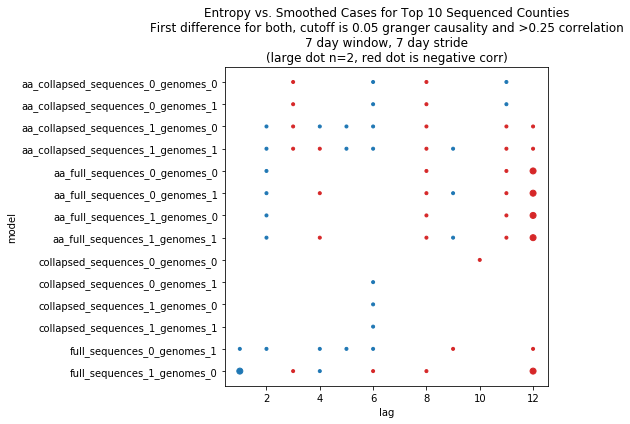

In [46]:
model_summary = pd.concat(location_dfs).reset_index(drop=True)
model_summary["lag_val"] = model_summary.lag.apply(lambda row: int(row.split("_")[1]))
model_summary["model_name"] = model_summary.model.apply(model_name_map)

fig, ax = plt.subplots(figsize=(8,6))

model_counts = model_summary.copy()
model_counts["count"] = model_counts.correlation.apply(lambda row: 1 if row > 0 else -1)
model_counts["lag"] = model_counts.lag.apply(lambda row: int(row.split("_")[1]))
model_counts = model_counts.groupby(["lag", "model"])["count"].sum().reset_index()
model_counts["color"] = model_counts["count"].apply(lambda row: "tab:blue" if row > 0 else "tab:red")
model_counts["count"] = (model_counts["count"] * 3) ** 2
model_counts["count"] = model_counts["count"].abs()
model_counts = model_counts.sort_values("model", ascending=False)
model_counts.plot.scatter(x="lag", y="model", s="count", c=model_counts["color"], ax=ax)

ax.set_title("Entropy vs. Smoothed Cases for Top 10 Sequenced Counties\nFirst difference for both, cutoff is 0.05 granger causality and >0.25 correlation\n7 day window, 7 day stride\n(large dot n=2, red dot is negative corr)")
plt.tight_layout()
plt.savefig("entropy_and_cases_first_diff_window_7_step_7_top_10.png", dpi=100, bbox_inches='tight')

3


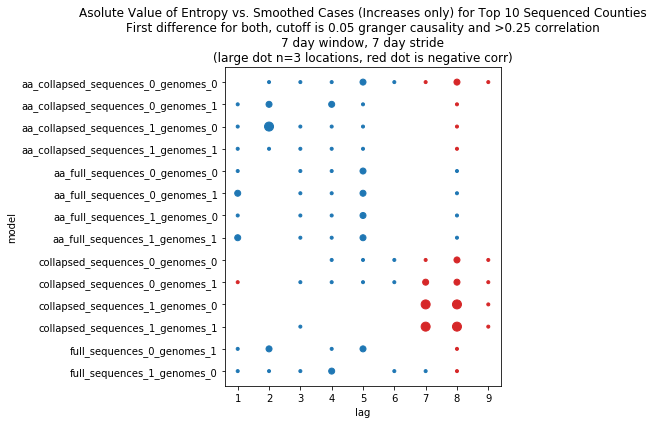

In [8]:
model_summary = pd.concat(location_dfs_abs).reset_index(drop=True)
model_summary["lag_val"] = model_summary.lag.apply(lambda row: int(row.split("_")[1]))
model_summary["model_name"] = model_summary.model.apply(model_name_map)

fig, ax = plt.subplots(figsize=(8,6))

model_counts = model_summary.copy()
model_counts["count"] = model_counts.correlation.apply(lambda row: 1 if row > 0 else -1)
model_counts["lag"] = model_counts.lag.apply(lambda row: int(row.split("_")[1]))
model_counts = model_counts.groupby(["lag", "model"])["count"].sum().reset_index()
print(model_counts["count"].max())
model_counts["color"] = model_counts["count"].apply(lambda row: "tab:blue" if row > 0 else "tab:red")
model_counts["count"] = (model_counts["count"] * 3) ** 2
model_counts["count"] = model_counts["count"].abs()
model_counts = model_counts.sort_values("model", ascending=False)
model_counts.plot.scatter(x="lag", y="model", s="count", c=model_counts["color"], ax=ax)

ax.set_title("Asolute Value of Entropy vs. Smoothed Cases (Increases only) for Top 10 Sequenced Counties\nFirst difference for both, cutoff is 0.05 granger causality and >0.25 correlation\n7 day window, 7 day stride\n(large dot n=3 locations, red dot is negative corr)")
plt.tight_layout()
plt.savefig("abs_entropy_and cases_first_diff_pos_only_window_7_step_7_top_10.png", dpi=100, bbox_inches='tight')

In [41]:
model_summary = model_summary[~model_summary["model"].isin(["aa_full_sequences_1_genomes_1", "aa_full_sequences_0_genomes_0"])]

In [ ]:
colors = "tab:blue tab:orange tab:green tab:red tab:purple tab:brown"

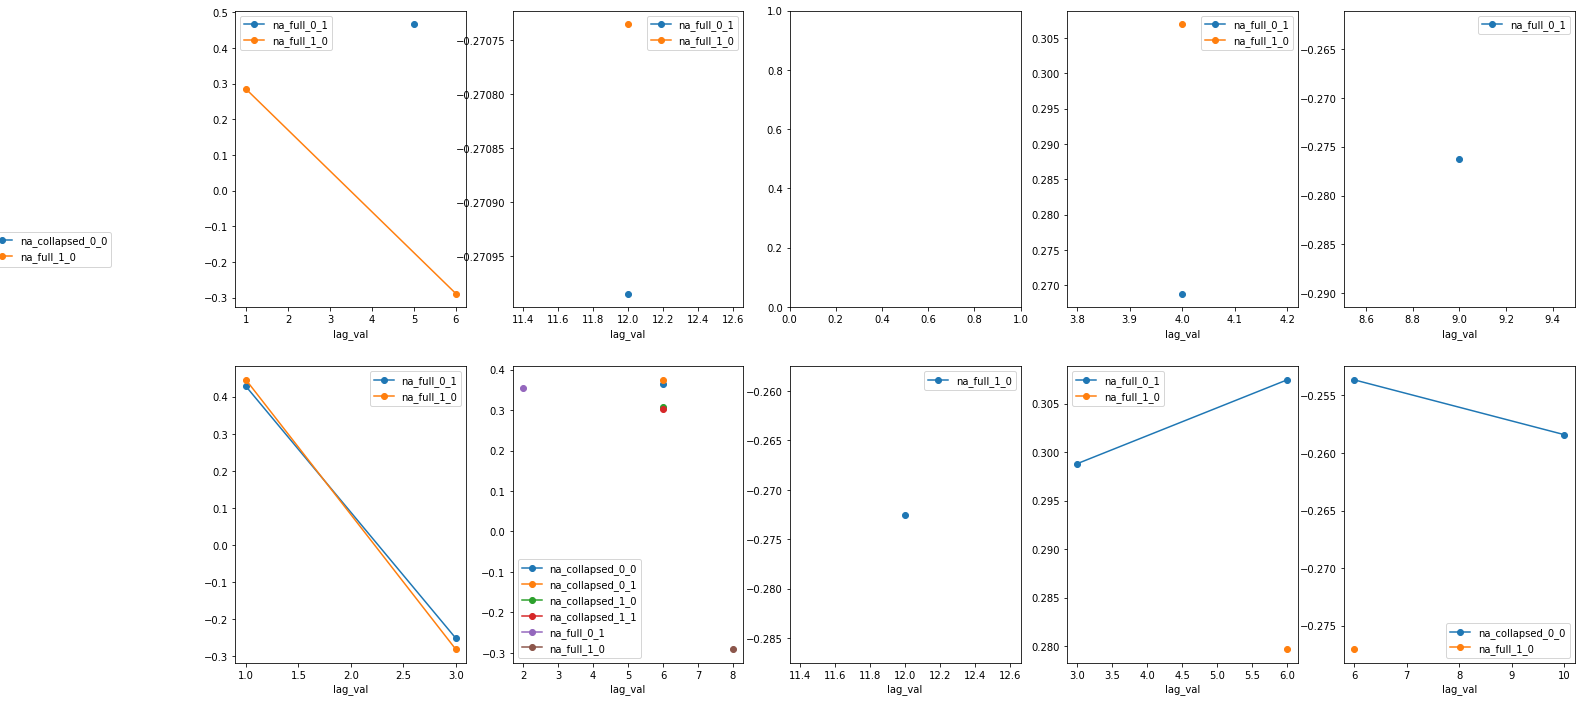

In [71]:
aa_cols = [c for c in model_summary.model.unique() if "aa" in c]

fig, axs = plt.subplots(2,5, figsize=(24,12))
ax = 0
for ix, location in enumerate(model_summary.location.unique()):
    ax = axs[ix//5, ix%5]
    
    for model, df in model_summary[model_summary.location == location].groupby("model"):
        model_name = df.model_name.unique()[0]
        if model in aa_cols:
            continue
#             df.plot(x="lag_val", y="correlation", ax=ax, label=model, linestyle="--", marker="^")
        else:
            df.plot(x="lag_val", y="correlation", ax=ax, label=model_name, marker="o")
    l1, h1 = ax.get_legend_handles_labels()
#     ax.get_legend().remove()
fig.legend(l1,h1, bbox_to_anchor=(-0.01, 0.55), loc="upper left")

In [18]:
model_summary["model_lag"] = model_summary.model + "_" + model_summary.lag
model_summary.model_lag.value_counts().sort_index()

aa_collapsed_sequences_0_genomes_0_lag_11    1
aa_collapsed_sequences_0_genomes_0_lag_3     1
aa_collapsed_sequences_0_genomes_0_lag_6     1
aa_collapsed_sequences_0_genomes_0_lag_8     1
aa_collapsed_sequences_0_genomes_1_lag_11    1
                                            ..
full_sequences_1_genomes_0_lag_12            2
full_sequences_1_genomes_0_lag_3             1
full_sequences_1_genomes_0_lag_4             1
full_sequences_1_genomes_0_lag_6             3
full_sequences_1_genomes_0_lag_8             1
Name: model_lag, Length: 70, dtype: int64

In [19]:
model_summary.model.value_counts() 

aa_full_sequences_0_genomes_1         13
aa_full_sequences_1_genomes_0         13
aa_full_sequences_0_genomes_0         13
aa_collapsed_sequences_1_genomes_1    13
aa_full_sequences_1_genomes_1         13
aa_collapsed_sequences_1_genomes_0    12
full_sequences_1_genomes_0            10
full_sequences_0_genomes_1             9
aa_collapsed_sequences_0_genomes_0     4
aa_collapsed_sequences_0_genomes_1     4
collapsed_sequences_0_genomes_0        3
collapsed_sequences_1_genomes_1        1
collapsed_sequences_0_genomes_1        1
collapsed_sequences_1_genomes_0        1
Name: model, dtype: int64

In [199]:
for model, df in pd.concat(location_dfs).reset_index(drop=True).groupby("model"):
    print(model+":")
    print(df.lag.value_counts())

aa_collapsed_sequences_0_genomes_0:
lag_1     1
lag_3     1
lag_7     1
lag_11    1
Name: lag, dtype: int64
aa_collapsed_sequences_0_genomes_1:
lag_1     1
lag_3     1
lag_7     1
lag_11    1
Name: lag, dtype: int64
aa_collapsed_sequences_1_genomes_0:
lag_3     1
lag_8     1
lag_11    1
lag_7     1
Name: lag, dtype: int64
aa_collapsed_sequences_1_genomes_1:
lag_1     1
lag_3     1
lag_7     1
lag_11    1
Name: lag, dtype: int64
aa_full_sequences_0_genomes_0:
lag_12    1
lag_3     1
lag_7     1
lag_10    1
lag_11    1
Name: lag, dtype: int64
aa_full_sequences_0_genomes_1:
lag_12    1
lag_3     1
lag_7     1
lag_10    1
lag_11    1
lag_4     1
Name: lag, dtype: int64
aa_full_sequences_1_genomes_0:
lag_12    1
lag_3     1
lag_7     1
lag_10    1
lag_11    1
Name: lag, dtype: int64
aa_full_sequences_1_genomes_1:
lag_12    1
lag_3     1
lag_7     1
lag_10    1
lag_11    1
lag_4     1
Name: lag, dtype: int64
collapsed_sequences_0_genomes_0:
lag_6    1
Name: lag, dtype: int64
collapsed_sequen

In [160]:
uncert

,full_sequences_0_genomes_1,full_sequences_1_genomes_0,collapsed_sequences_0_genomes_0,collapsed_sequences_0_genomes_1,collapsed_sequences_1_genomes_0,collapsed_sequences_1_genomes_1,aa_full_sequences_0_genomes_0,aa_full_sequences_0_genomes_1,aa_full_sequences_1_genomes_0,aa_full_sequences_1_genomes_1,aa_collapsed_sequences_0_genomes_0,aa_collapsed_sequences_0_genomes_1,aa_collapsed_sequences_1_genomes_0,aa_collapsed_sequences_1_genomes_1
date,,,,,,,,,,,,,,
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11,-0.002948,-0.002948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-25,0.005252,0.012155,6.328697,5.650385,2.796637,2.674347,0.001135,0.000574,0.001135,0.000574,3.997417,3.607761,1.443270,1.439079
2020-04-08,-0.004619,-0.010247,-1.144587,-0.898939,-0.917866,-0.858837,-0.000987,-0.000472,-0.000987,-0.000472,-1.997417,-1.689465,-0.534276,-0.531395
2020-04-15,0.028500,0.049306,4.481661,4.083870,4.812830,4.792041,1.480728,0.648605,1.480728,0.648605,10.471596,8.073948,6.284932,5.508832
2020-04-22,0.034498,0.057570,1.304341,1.386202,1.708707,1.712291,2.997455,2.888926,2.997455,2.888926,2.770877,2.652503,3.706344,3.490137
2020-04-29,-0.017571,-0.036601,-0.911696,-1.075532,-1.491301,-1.467295,-3.688081,-3.209676,-3.688081,-3.209676,-2.878604,-2.447833,-3.974667,-3.458027
2020-05-06,-0.016840,-0.018124,-0.015913,0.030862,0.193959,0.194842,7.337776,5.070723,7.337776,5.070723,3.863462,4.083736,6.659836,4.803468
2020-05-13,0.246095,0.290019,0.932856,1.082323,1.097269,1.066325,5.205325,6.338348,5.205325,6.338348,4.067600,4.374378,3.895783,4.940960


In [79]:
sample_sizes = []
granger_ps = {col:[] for col in uncert.columns}
for col_name in uncert.columns:
    col = uncert[col_name]
    granger_df = pd.concat([uncert_cases.cases, col], axis=1).dropna()
    sample_sizes.append(granger_df.shape[0])
    granger_results = grangercausalitytests(granger_df, min(granger_df.shape[0]-20, 12), verbose=False)
    for lag in range(1, 13):
        try:
            p_value = granger_results[lag][0]['ssr_chi2test'][1]
        except:
            p_value = np.nan
        granger_ps[col_name].append(p_value)
granger_ps = pd.DataFrame(granger_ps)
granger_ps.index = [f"lag_{i}" for i in range(1,13)]
granger_ps_check = granger_ps < 0.05

corrs = {col:[] for col in uncert.columns}
for col_name in uncert.columns:
    col = uncert[col_name]
    for lag in range(1, 13):
        shifted_col = col.shift(lag)
        corr = uncert_cases["cases"].corr(shifted_col)
        corrs[col_name].append(corr)
corrs = pd.DataFrame(corrs)
corrs.index = [f"lag_{i}" for i in range(1,13)]
corrs_check = corrs.abs() > 0.3

In [93]:
passed_combos = corrs[(corrs_check) & (granger_ps_check)].melt(ignore_index=False)
passed_combos = passed_combos.reset_index().rename(columns={"index":"lag"}).dropna()
passed_combos["location"] = location


,lag,variable,value,location
4,lag_5,full_sequences_0_genomes_1,0.467472,Houston
75,lag_4,aa_full_sequences_0_genomes_0,0.386057,Houston
78,lag_7,aa_full_sequences_0_genomes_0,-0.341194,Houston
87,lag_4,aa_full_sequences_0_genomes_1,0.409571,Houston
90,lag_7,aa_full_sequences_0_genomes_1,-0.350261,Houston
99,lag_4,aa_full_sequences_1_genomes_0,0.386057,Houston
102,lag_7,aa_full_sequences_1_genomes_0,-0.341194,Houston
111,lag_4,aa_full_sequences_1_genomes_1,0.409571,Houston
114,lag_7,aa_full_sequences_1_genomes_1,-0.350261,Houston
123,lag_4,aa_collapsed_sequences_0_genomes_0,0.332827,Houston


In [69]:

granger_ps

,full_sequences_0_genomes_1,full_sequences_1_genomes_0,collapsed_sequences_0_genomes_0,collapsed_sequences_0_genomes_1,collapsed_sequences_1_genomes_0,collapsed_sequences_1_genomes_1,aa_full_sequences_0_genomes_0,aa_full_sequences_0_genomes_1,aa_full_sequences_1_genomes_0,aa_full_sequences_1_genomes_1,aa_collapsed_sequences_0_genomes_0,aa_collapsed_sequences_0_genomes_1,aa_collapsed_sequences_1_genomes_0,aa_collapsed_sequences_1_genomes_1
sample_size,44.000000,44.000000,4.400000e+01,44.000000,44.000000,44.000000,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01,2.700000e+01
granger_lag_1,0.101414,0.044613,8.933339e-02,0.237528,0.215141,0.310006,1.521841e-01,1.519990e-01,1.521841e-01,1.519990e-01,5.809713e-02,8.305179e-02,4.573374e-02,4.656946e-02
granger_lag_2,0.244435,0.068741,6.219120e-02,0.292941,0.388659,0.446829,2.420939e-01,1.813005e-01,2.420939e-01,1.813005e-01,9.682337e-02,1.225844e-01,9.234351e-02,6.465596e-02
granger_lag_3,0.097222,0.055167,9.411449e-02,0.536799,0.497893,0.602013,1.902874e-01,7.308620e-02,1.902874e-01,7.308620e-02,5.958962e-02,3.931082e-02,1.474671e-01,5.237021e-02
granger_lag_4,0.135483,0.091767,1.845781e-01,0.725018,0.677153,0.761472,7.408226e-04,9.179916e-04,7.408226e-04,9.179916e-04,3.005066e-02,3.430450e-03,1.260691e-03,5.756176e-04
granger_lag_5,0.006744,0.027525,1.514780e-01,0.583239,0.611628,0.663302,1.539683e-05,1.527609e-07,1.539683e-05,1.527609e-07,2.117948e-03,3.587278e-04,4.253490e-04,4.189573e-05
granger_lag_6,0.000435,0.001684,1.125229e-02,0.143768,0.301230,0.307657,9.956852e-10,4.730226e-08,9.956852e-10,4.730226e-08,1.676449e-07,2.066672e-09,1.350762e-12,1.184035e-11
granger_lag_7,0.000547,0.002336,2.560740e-03,0.224156,0.417191,0.414865,2.159595e-10,9.769698e-08,2.159595e-10,9.769698e-08,1.044641e-10,7.872518e-09,3.082477e-12,6.802891e-12
granger_lag_8,0.001308,0.005429,5.802952e-03,0.181680,0.493162,0.445504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
granger_lag_9,0.000413,0.000829,2.889946e-03,0.127869,0.265313,0.224005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
granger_ps


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4960  , p=0.1220  , df_denom=40, df_num=1
ssr based chi2 test:   chi2=2.6832  , p=0.1014  , df=1
likelihood ratio test: chi2=2.6028  , p=0.1067  , df=1
parameter F test:         F=2.4960  , p=0.1220  , df_denom=40, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2411  , p=0.3008  , df_denom=37, df_num=2
ssr based chi2 test:   chi2=2.8176  , p=0.2444  , df=2
likelihood ratio test: chi2=2.7271  , p=0.2557  , df=2
parameter F test:         F=1.2411  , p=0.3008  , df_denom=37, df_num=2
0.1014138177962157
0.24443454332026107


In [36]:
uncert.columns

Index(['full_sequences_0_genomes_1', 'full_sequences_1_genomes_0',
       'collapsed_sequences_0_genomes_0', 'collapsed_sequences_0_genomes_1',
       'collapsed_sequences_1_genomes_0', 'collapsed_sequences_1_genomes_1',
       'aa_full_sequences_0_genomes_0', 'aa_full_sequences_0_genomes_1',
       'aa_full_sequences_1_genomes_0', 'aa_full_sequences_1_genomes_1',
       'aa_collapsed_sequences_0_genomes_0',
       'aa_collapsed_sequences_0_genomes_1',
       'aa_collapsed_sequences_1_genomes_0',
       'aa_collapsed_sequences_1_genomes_1'],
      dtype='object')

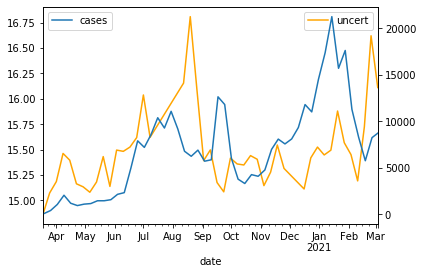

In [4]:
fig, ax = plt.subplots()
twinx = ax.twinx()

cases.resample("7D").sum().plot(ax=twinx)
uncert["full_sequences_0_genomes_1"].plot(ax=ax, color="orange", label="uncert")
ax.legend()

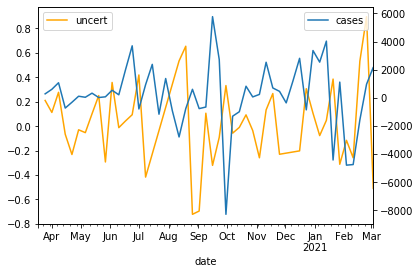

In [8]:
fig, ax = plt.subplots()
twinx = ax.twinx()

cases.loc[uncert.index.min():].resample("7D").sum().diff().plot(ax=twinx)
uncert["full_sequences_0_genomes_1"].diff().plot(ax=ax, color="orange", label="uncert")
ax.legend()

In [7]:
uncert.index

DatetimeIndex(['2020-03-18', '2020-03-25', '2020-04-01', '2020-04-08',
               '2020-04-15', '2020-04-22', '2020-04-29', '2020-05-06',
               '2020-05-13', '2020-05-20', '2020-05-27', '2020-06-03',
               '2020-06-10', '2020-06-17', '2020-06-24', '2020-07-01',
               '2020-07-08', '2020-08-12', '2020-08-19', '2020-08-26',
               '2020-09-02', '2020-09-09', '2020-09-16', '2020-09-23',
               '2020-09-30', '2020-10-07', '2020-10-14', '2020-10-21',
               '2020-10-28', '2020-11-04', '2020-11-11', '2020-11-18',
               '2020-11-25', '2020-12-16', '2020-12-23', '2020-12-30',
               '2021-01-06', '2021-01-13', '2021-01-20', '2021-01-27',
               '2021-02-03', '2021-02-10', '2021-02-17', '2021-02-24',
               '2021-03-03'],
              dtype='datetime64[ns]', name='date', freq=None)

In [9]:
cases.loc[uncert.index.min():].resample("7D").sum().diff().index

DatetimeIndex(['2020-03-18', '2020-03-25', '2020-04-01', '2020-04-08',
               '2020-04-15', '2020-04-22', '2020-04-29', '2020-05-06',
               '2020-05-13', '2020-05-20', '2020-05-27', '2020-06-03',
               '2020-06-10', '2020-06-17', '2020-06-24', '2020-07-01',
               '2020-07-08', '2020-07-15', '2020-07-22', '2020-07-29',
               '2020-08-05', '2020-08-12', '2020-08-19', '2020-08-26',
               '2020-09-02', '2020-09-09', '2020-09-16', '2020-09-23',
               '2020-09-30', '2020-10-07', '2020-10-14', '2020-10-21',
               '2020-10-28', '2020-11-04', '2020-11-11', '2020-11-18',
               '2020-11-25', '2020-12-02', '2020-12-09', '2020-12-16',
               '2020-12-23', '2020-12-30', '2021-01-06', '2021-01-13',
               '2021-01-20', '2021-01-27', '2021-02-03', '2021-02-10',
               '2021-02-17', '2021-02-24', '2021-03-03', '2021-03-10',
               '2021-03-17', '2021-03-24', '2021-03-31', '2021-04-07',
      

In [ ]:
uncert = pd.concat(map(pd.read_csv, houston_data))
uncert["date"] = pd.to_datetime(uncert.graph_name.apply(lambda row: row.split("_")[0]))
# uncert["end"] = pd.to_datetime(uncert.graph_name.apply(lambda row: row.split("_")[-1]))
uncert = uncert.set_index("date").drop(columns=["graph_name"])
uncert = uncert.reindex(pd.date_range(uncert.index.min(), uncert.index.max(), freq=f"{5}D"))
uncert = uncert.fillna(0)
uncert = uncert.reindex(cases.index)
uncert = uncert.fillna(method="ffill")
uncert = uncert.replace(0, np.nan)

uncert.columns = ["full_none", "full_genomes", "full_seqs", "full_genomes+seqs", "collapsed_none", "collapsed_genomes", "collapsed_seqs", "collapsed_genomes+seqs"]